# Ford GoBike System Data
### by `Hamid Khodabandehloo`

## Table of Contents
<ul>
<li><a href="#Intro">Introduction</a></li>
<li><a href="#Wrangling">Data Wrangling</a></li>
<li><a href="#questions">Research questions</a></li>
<li><a href="#Univariate">Univariate Exploration</a></li>
<li><a href="#Bivariate">Bivariate Exploration</a></li>
<li><a href="#Multivariate">Multivariate Exploration</a></li>
<li><a href="#conclusion">Conclusion</a></li>
</ul>

<a id='Wrangling'></a>
## Introduction
In this notebook, I have analyzed [Ford GoBike system data](https://s3.amazonaws.com/baywheels-data/index.html) for the year of 2019. This dataset includes stations and trips information of three cities; San Francisco, San Jose and Oakland. Data is published monthly in a zipped `CSV` file. In this work, I am interested in people's behaviour towards the bike-sharing system. I would like to know how and for what purpose people are using the system. I have defined <a href="#questions">9 research questions</a> and answered all the questions with one or more data visualizations. You can find a summary of the answers to all the questions in the <a href="#conclusion">conclusion</a> section.

**As the trip dataset has about 2.5 milion records, some code related to this dataset will take up to 3 minutes to execute**


<a id='Wrangling'></a>
## Preliminary Wrangling

> The dataset includs informations about station and trips of a bike sharing application (primarily, it was in 12 `csv` files with 15 columns and about 250k rows overal). In the `Wrangling.py` file, I merged the 12 files and fixed five quality and one tidiness issues. The wrangling process resulted in separating the data into two tables and removing about four percent of the data. The trip data includes start station id, end station id, start time, end time, duration and bike id. Stations data includes name, longitude and latitude of the bike-sharing stations.

In [56]:
# import all packages and set plots to be embedded inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas.testing as tm
import matplotlib.pyplot as plt
import seaborn as sb
# conda install -c conda-forge gmaps
import gmaps
from ipywidgets.embed import embed_minimal_html
import networkx as nx
# conda install -c conda-forge pyproj
import pyproj as Proj
import math
import plotly_express as px
import plotly
from Wrangling import downloadFile , downloadAllFiles, mergeAllFiles, clean, haversine
%matplotlib inline

### Data Wrangling
> Data gathering and cleaning is done in `Wrangling.py` and called in following cell. The clean data is stored in two csv files (`Stations.csv` and `Trips.csv`). The clean files are in the home directory of the project and you do not need to execute the cell every time.

In [2]:
#Download 12 files for each month of 2019 and unzip them
downloadAllFiles()

#Merge all 12 files in All.csv file and remove the rest
mergeAllFiles()

# Clean 5 quality issues and one tidiness issue
clean()

<a id='questions'></a>
### Research questions
> Clean data is imported in this section. Our main motivation is to understand people's bike riding behaviours such as when, where and why they use the bikes. These are the main question we are trying to answer in this project:
1. **Is there any relationship between the day of the week and trip duration, distance and speed?** 
2. **How are the stations distributed geographically?**
3. **What time in a day do people use bikes more frequently?**
4. **How did bike usage change in different months?**
5. **How different users (Subscribers or casual customers) use bikes?**
6. **How subscribers' and casual users' trips are distributed in each city?**
7. **Are there any suspicious activities?**
8. **Is there any travel between cities?** 
9. **How much gas have been saved by the Ford GoBike system?**

Short answer to the all questions are provided in the <a href="#conclusion">Conclusion</a> section.

In [2]:
df_stations = pd.read_csv('stations.csv', low_memory=False)
df_trips = pd.read_csv('trips.csv', low_memory=False)

In [3]:
df_stations.head()

,station_id,latitude,longitude,name
0,3,37.786375,-122.404904,Powell St BART Station (Market St at 4th St)
1,4,37.785881,-122.408915,Cyril Magnin St at Ellis St
2,5,37.783899,-122.408445,Powell St BART Station (Market St at 5th St)
3,6,37.804770,-122.403234,The Embarcadero at Sansome St
4,7,37.804562,-122.271738,Frank H Ogawa Plaza


In [4]:
df_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   station_id  456 non-null    int64  
 1   latitude    456 non-null    float64
 2   longitude   456 non-null    float64
 3   name        456 non-null    object 
dtypes: float64(2), int64(1), object(1)
memory usage: 14.4+ KB


In [5]:
df_stations.describe()

,station_id,latitude,longitude
count,456.000000,456.000000,456.000000
mean,247.789474,37.721975,-122.056325
std,142.295327,0.422517,3.175100
min,3.000000,37.309014,-122.495241
25%,128.500000,37.740096,-122.411729
50%,245.500000,37.776382,-122.384696
75%,376.250000,37.803313,-122.253071
max,498.000000,45.510000,-73.570000


In [6]:
df_stations.shape

(456, 4)

In [7]:
df_trips.head()

,duration_sec,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,bike_share_for_all_trip
0,80825,2019-01-31 17:57:44.613,2019-02-01 16:24:49.864,229,196,4861,Subscriber,No
1,65900,2019-01-31 20:58:33.886,2019-02-01 15:16:54.173,4,134,5506,Subscriber,No
2,62633,2019-01-31 18:06:52.924,2019-02-01 11:30:46.530,245,157,2717,Customer,No
3,44680,2019-01-31 19:46:09.719,2019-02-01 08:10:50.318,85,53,4557,Customer,No
4,60709,2019-01-31 14:19:01.541,2019-02-01 07:10:51.065,16,28,2100,Customer,No


In [8]:
df_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2407190 entries, 0 to 2407189
Data columns (total 8 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   duration_sec             int64 
 1   start_time               object
 2   end_time                 object
 3   start_station_id         int64 
 4   end_station_id           int64 
 5   bike_id                  int64 
 6   user_type                object
 7   bike_share_for_all_trip  object
dtypes: int64(4), object(4)
memory usage: 146.9+ MB


In [9]:
df_trips.describe()

,duration_sec,start_station_id,end_station_id,bike_id
count,2.407190e+06,2.407190e+06,2.407190e+06,2.407190e+06
mean,8.040941e+02,1.462486e+02,1.424772e+02,9.290447e+03
std,1.899553e+03,1.221957e+02,1.213281e+02,5.046314e+04
min,6.000000e+01,3.000000e+00,3.000000e+00,4.000000e+00
25%,3.580000e+02,4.700000e+01,4.200000e+01,1.877000e+03
50%,5.690000e+02,1.040000e+02,1.010000e+02,3.727000e+03
75%,8.830000e+02,2.420000e+02,2.390000e+02,7.170000e+03
max,8.623000e+04,4.980000e+02,4.980000e+02,9.984300e+05


In [10]:
df_trips.shape

(2407190, 8)

### What is the structure of your dataset?

> Information about the stations are stored in `df_stations` which includes folowing columns:
><br> **station_id:** Id of the station.
><br> **latitude:** Latitude GPS coordinate.
><br> **longitude:** Longitude GPS coordinate.
><br> **name:** Name of the station.
><br> This table has **4 columns** and **456 rows**.
><br>
><br> Information about trips are stored in df_trips which includes folowing columns:
><br> **duration_sec:** Duration of the trip in seconds.
><br> **start_time:** Start time of the trip.
><br> **end_time:** End time of the trip.
><br> **start_station_id:** The station that trip started from.
><br> **end_station_id:** The station that trip ended in.
><br> **bike_id:** Id of the bike used for the trip.
><br> **user_type:** Type of the user (subscriber or customer – “Subscriber” = Member or “Customer” = Casual)                
> **bike_share_for_all_trip:** If the bike is used for all trip.
><br> This table has **8 columns** and **2407190 rows**.

> These two table can be joined based on `station_id`, `start_station_id` and `end_station_id` columns.



### What is/are the main feature(s) of interest in your dataset?

> Trip duration, start and end time of a trip, start and end GPS cordinates of a trip and user type are the most important features that I am  going to use. There are some other features that do not exist in the dataset such as city, trip distance and trip mean speed. I will calculate and add them to the trip dataset.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Trip duration, distance and date can help to understand user's behaviour toward the bike sharinf system.

In [11]:
# In this cell I add some columns to the data set to make it easier to work.

# Add week day of start and end time of the trip to df_trips
df_trips['start_time'] = pd.to_datetime(df_trips['start_time'])
df_trips['end_time'] = pd.to_datetime(df_trips['end_time'])
    
df_trips['start_weekday'] = df_trips['start_time'].dt.dayofweek
df_trips['end_weekday'] = df_trips['end_time'].dt.dayofweek


# Remove stations outside the region
df_stations = df_stations.query('latitude > 37.207932 and latitude < 37.881729 and longitude > -122.671773 and longitude < -121.698069')

# Add city to df_stations
df_stations['city'] = ''

df_stations.loc[(df_stations['latitude'] > 37.691495) & (df_stations['latitude'] < 37.825785) & (df_stations['longitude'] < -122.376299) &  (df_stations['longitude'] > -122.533738),['city']] = 'San Francisco'
df_stations.loc[(df_stations['latitude'] > 37.711895) & (df_stations['latitude'] < 37.899914) & (df_stations['longitude'] < -22.141754) &  (df_stations['longitude'] > -122.360498),['city']] = 'Oakland'
df_stations.loc[df_stations['city']=="",['city']] = 'San Jose'

# Join stations and trip data 
df = df_stations.merge(df_trips, how='inner',left_on='station_id', right_on='start_station_id' ).merge(df_stations, how='inner',left_on='end_station_id', right_on='station_id')

# Add distance and speed to df
df['distance'] = df.apply(lambda x: haversine((x['latitude_x'], x['longitude_x']),(x['latitude_y'], x['longitude_y'])), axis=1)
df['speed'] = df.apply(lambda x : round((x['distance']/1000) / (x['duration_sec']/3600),2), axis=1)

# Limit trips to under 2 hours
df_full_trips = df_trips.copy()
df_trips = df_trips.query('duration_sec <= 2*3600')
df_full = df.copy()
df = df.query('duration_sec <= 2*3600')

# Trips between cities dataset
df_outOfCityTrips = df[df['city_x'] != df['city_y']]

<a id='Univariate'></a>
## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

### Day of the week
#### Number of trips:
> Number of trips are considerably higher during the week comparing to the weekend. It can be an indication that people use bikes to commute to work.

#### Mean duration of trips:
> The mean duration of trips are about 3 minutes more at weekends.

#### Mean distance of trips:
> The mean distance of trips are slightly shorter during weekends.


#### Mean speed of trips:
> The mean speed of trips is about 1.5km/h less during weekends.

>As we can see in the following graphs, people's behaviour towards riding bikes is very different during weekdays and weekends. During weekdays people have more trips and ride faster. They go longer distances slightly in a shorter time. We can conclude that during weekdays people use bikes more seriously, probably for commuting between home and work. But at weekends it is more for pleasure.

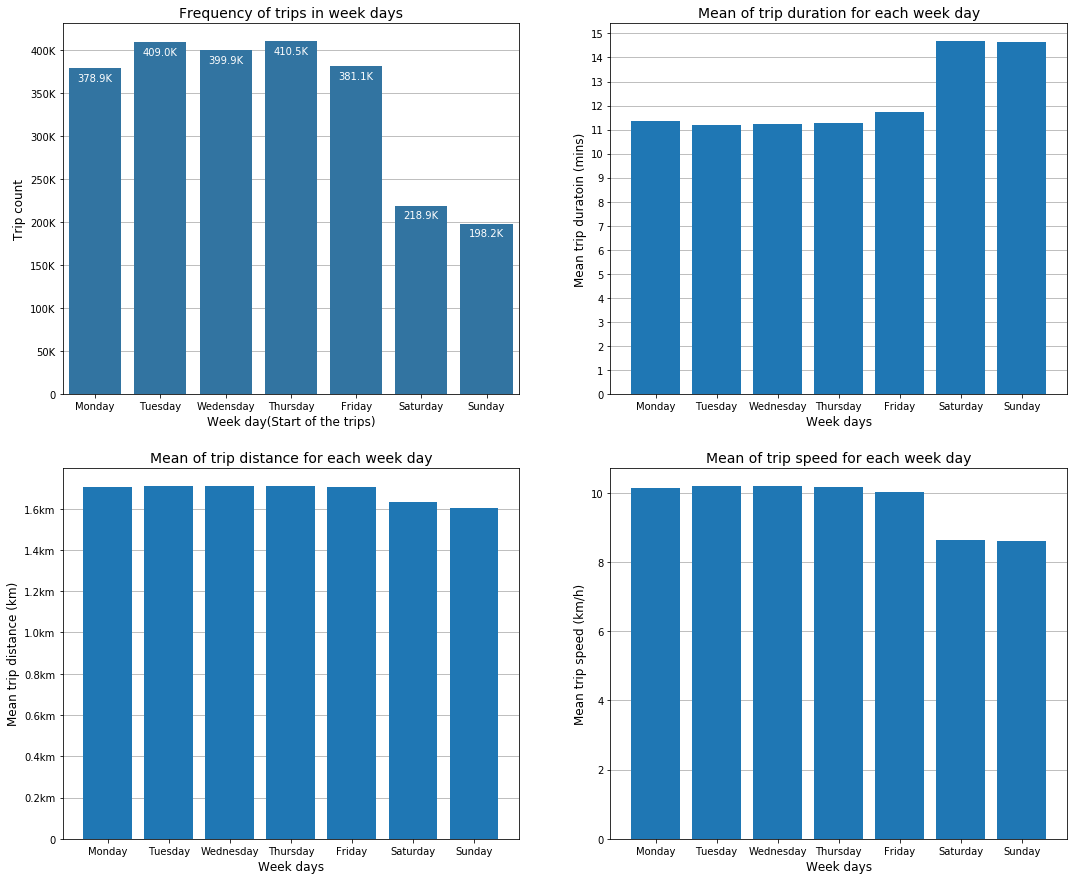

In [55]:
# Trip frequency during weekday and weekends

plt.figure(figsize=[18,15])

plt.subplot(2,2,1)
base_color = sb.color_palette()[0]
sb.countplot(data=df_trips, x = 'start_weekday', color=base_color);
plt.xlabel('Week day(Start of the trips)',fontsize=12)
plt.ylabel('Trip count',fontsize=12)
plt.title('Frequency of trips in week days',fontsize=14)
plt.yticks(np.arange(0, 450000, 50000), ['0', '50K', '100K','150K','200K','250K','300K','350K','400K']);
n_points=df_trips.shape[0]

locs, labels = plt.xticks()
for loc, label in zip(locs, labels):
    count = len(df_trips[df_trips['start_weekday'] == int(label.get_text())])
    pct_string = '{:0.1f}K'.format(count/1000)
    plt.text(loc, count-15000, pct_string, ha='center', color='w' )
plt.xticks([0,1,2,3,4,5,6],['Monday', 'Tuesday', 'Wedensday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True

plt.subplot(2,2,2);
data = df_trips.groupby('start_weekday').mean()['duration_sec'].reset_index()
plt.bar(data=data, x = 'start_weekday', height='duration_sec')
plt.xticks(np.arange(0,7,1), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.yticks(np.arange(0,901,60),np.arange(0,16,1))
plt.title('Mean of trip duration for each week day', fontsize = 14)
plt.ylabel('Mean trip duratoin (mins)', fontsize = 12)
plt.xlabel('Week days', fontsize = 12)
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True

plt.subplot(2,2,3);
data = df.groupby('start_weekday').mean()['distance'].reset_index()
plt.bar(data=data, x = 'start_weekday', height='distance')
plt.xticks(np.arange(0,7,1), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.yticks(np.arange(0,1601,200),['0','0.2km','0.4km','0.6km','0.8km','1.0km','1.2km','1.4km','1.6km'])
plt.title('Mean of trip distance for each week day', fontsize = 14)
plt.ylabel('Mean trip distance (km)', fontsize = 12)
plt.xlabel('Week days', fontsize = 12)
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True

plt.subplot(2,2,4);
data = df.groupby('start_weekday').mean()['speed'].reset_index()
plt.bar(data=data, x = 'start_weekday', height='speed')
plt.xticks(np.arange(0,7,1), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
#plt.yticks(np.arange(0,1601,200),['0','0.2km','0.4km','0.6km','0.8km','1.0km','1.2km','1.4km','1.6km'])
plt.title('Mean of trip speed for each week day', fontsize = 14)
plt.ylabel('Mean trip speed (km/h)', fontsize = 12)
plt.xlabel('Week days', fontsize = 12)
plt.grid(True, axis='y', which='both')
plt.rcParams['axes.axisbelow'] = True
plt.savefig('weekR.png')

### City Analysis:
#### Number of stations:
> There are more bike sharing stations in San Francisco comparing to Oakland and San Jose. San Francisco has 230 stations, Oakland 132 and San Jose 94. However, San Jose is the most populated city among these three cities but number of bike stations are less than other cities. To understand number of stations based on population see the following table:

| City | Population | Bike statation per 100,000 people |
| --- | --- | --- |
| San Jose | 1,035,000 | 9.37 |
| San Francisco| 884,000 | 26 |
| Oakland | 425,000 | 31 |


>Oakland has the most bike stations per 100,000 people.

#### Mean of trip duration:
>Trips are generally longer in San Francisco. Trips in Oakland and San Jose takes about 10 minutes. This number in San Francisco is about 12 minutes.

#### Mean distance of trips:
> Trips distance in San Francisco 250 meters longer than Oakland and about 600 meters longer than San Jose.

#### Mean speed of trips:
> People in Oakland ride faster than San Fransisco and San Jose.

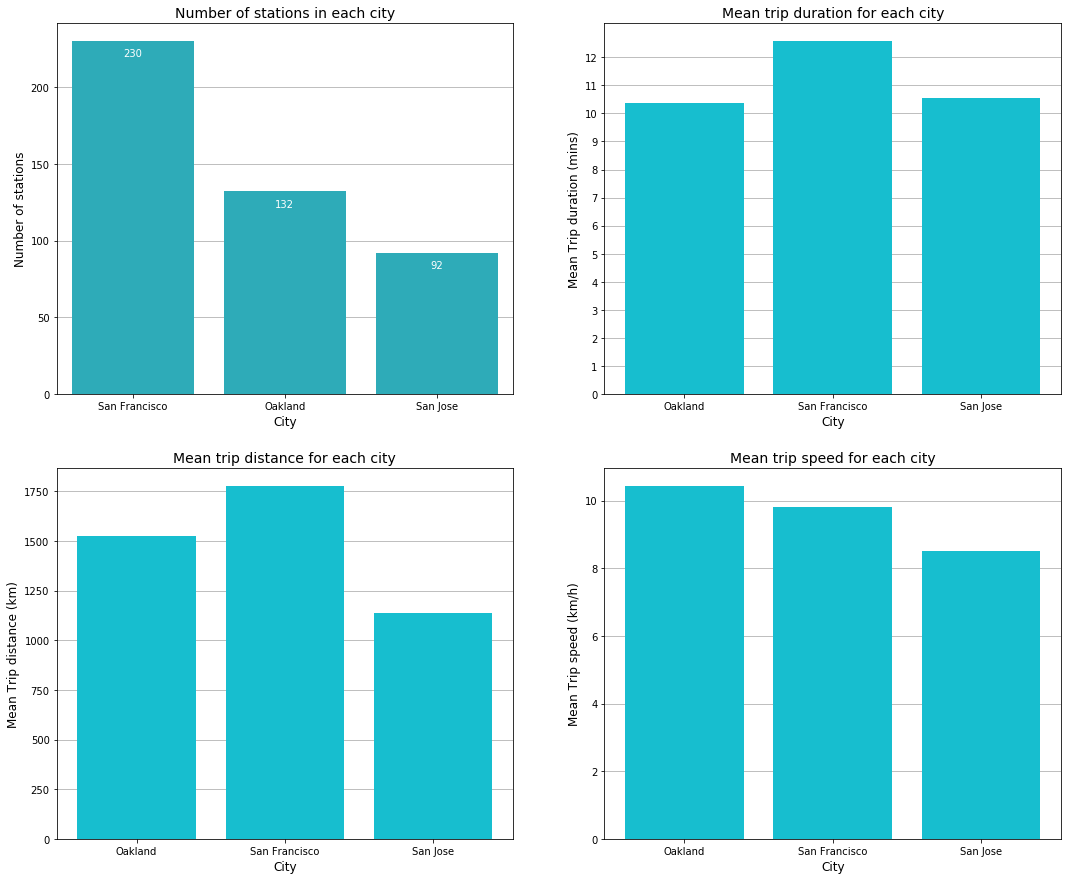

In [13]:
# City analysis
plt.figure(figsize=[18,15])

plt.subplot(2,2,1)
base_color = sb.color_palette()[9]
sb.countplot(data=df_stations, x = 'city', color=base_color);
plt.title('Number of stations in each city', fontsize = 14);
plt.ylabel('Number of stations',fontsize = 12);
plt.xlabel('City',fontsize = 12);

locs, labels = plt.xticks()
for loc, label in zip(locs, labels):
    count = len(df_stations[df_stations['city'] == label.get_text()])
    plt.text(loc, count-10, count, ha='center', color='w' )
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True

    
plt.subplot(2,2,2)
base_color = sb.color_palette()[9]
data = df.groupby('city_x').mean()['duration_sec'].reset_index()
plt.bar(data=data, x = 'city_x',height='duration_sec', color=base_color);
plt.title('Mean trip duration for each city', fontsize = 14)
plt.ylabel('Mean Trip duration (mins)',fontsize = 12);
plt.xlabel('City',fontsize = 12);
plt.yticks(np.arange(0,721,60), np.arange(0,13,1));
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True


plt.subplot(2,2,3)
base_color = sb.color_palette()[9]
data = df.groupby('city_x').mean()['distance'].reset_index()
plt.bar(data=data, x = 'city_x',height='distance', color=base_color);
plt.title('Mean trip distance for each city', fontsize = 14)
plt.ylabel('Mean Trip distance (km)',fontsize = 12);
plt.xlabel('City',fontsize = 12);
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True


plt.subplot(2,2,4)
base_color = sb.color_palette()[9]
data = df.groupby('city_x').mean()['speed'].reset_index()
plt.bar(data=data, x = 'city_x',height='speed', color=base_color);
plt.title('Mean trip speed for each city', fontsize = 14)
plt.ylabel('Mean Trip speed (km/h)',fontsize = 12);
plt.xlabel('City',fontsize = 12);
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True


### Hour of the trip:
#### Number of trips:
> Between 7 to 9 am and 16 to 18 pm are peak time for bike usage. These hours are the times when usually people commute. This is another indication that people are using bikes for commuting between home and work. 
#### Mean of trip durations:
> Trip duration mean is almost the same in different hours of a day.


#### Mean distance of trips:
> Similar to number of trips, trip duration is longer during the peak hours.

#### Mean speed of trips:
> People generally ride faster from 5 to 9 am.

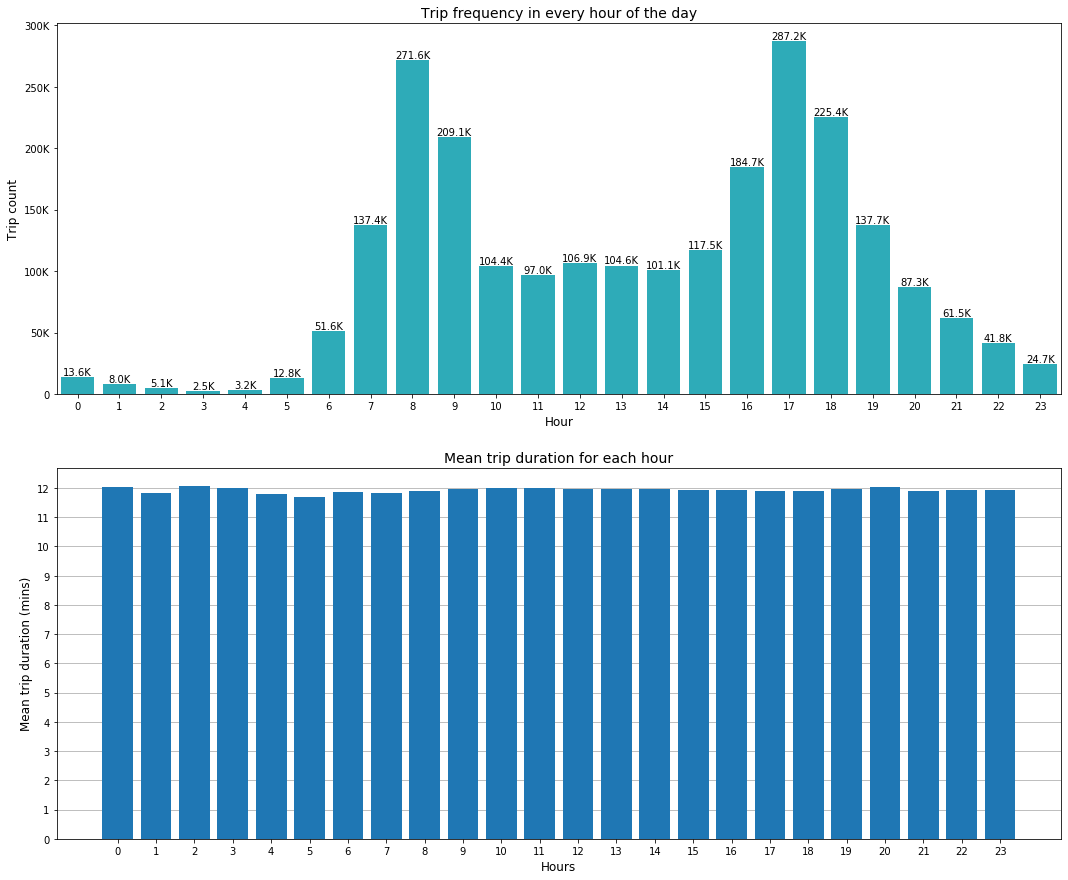

In [14]:
plt.figure(figsize=[18,15])


plt.subplot(2,1,1)
base_color = sb.color_palette()[9]
data = df_trips['start_time'].dt.hour.reset_index()
sb.countplot(data=data, x='start_time', color=base_color);
plt.title('Trip frequency in every hour of the day', fontsize = 14)
plt.xlabel('Hour', fontsize=12);
plt.ylabel('Trip count', fontsize=12);
locs, lables = plt.xticks()
for loc,label in zip(locs, lables):
    count = len(data[data['start_time'] == int(label.get_text())])
    plt.text(loc, count+1500,str(round(count/1000,1)) +'K', ha='center', color='black')
plt.yticks(np.arange(0,300001, 50000), ['0','50K','100K','150K','200K','250K','300K']);

plt.subplot(2,1,2);
data = df_trips.groupby(df['start_time'].dt.hour).mean()['duration_sec'].reset_index()
plt.bar(data=data, x = 'start_time', height='duration_sec')
plt.xticks(np.arange(0,24,1));
plt.yticks(np.arange(0,750,60), np.arange(0,13,1));
plt.title('Mean trip duration for each hour', fontsize = 14)
plt.xlabel('Hours', fontsize=12)
plt.ylabel('Mean trip duration (mins)', fontsize=12)
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True

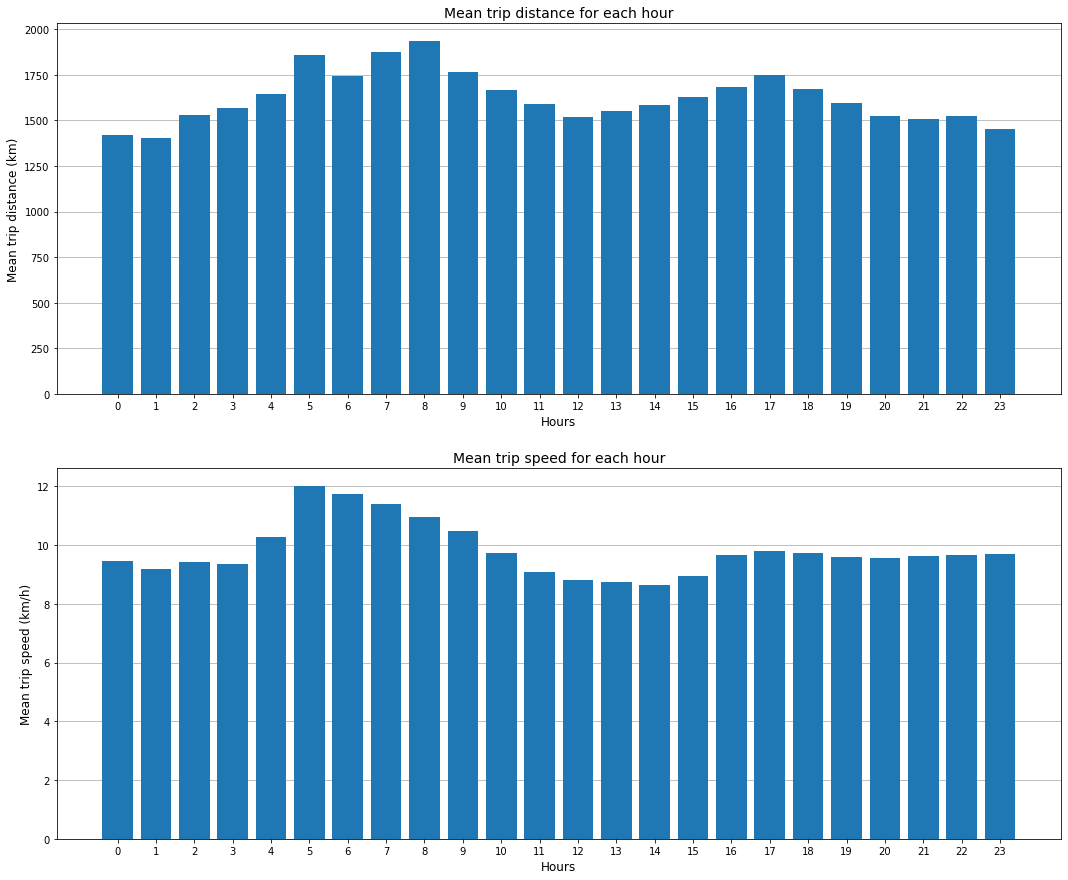

In [15]:
plt.figure(figsize=[18,15])

plt.subplot(2,1,1);
data = df.groupby(df['start_time'].dt.hour).mean()['distance'].reset_index()
plt.bar(data=data, x = 'start_time', height='distance')
plt.xticks(np.arange(0,24,1));
plt.title('Mean trip distance for each hour', fontsize = 14)
plt.xlabel('Hours', fontsize=12)
plt.ylabel('Mean trip distance (km)', fontsize=12)
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True


plt.subplot(2,1,2);
data = df.groupby(df['start_time'].dt.hour).mean()['speed'].reset_index()
plt.bar(data=data, x = 'start_time', height='speed')
plt.xticks(np.arange(0,24,1));
plt.title('Mean trip speed for each hour', fontsize = 14)
plt.xlabel('Hours', fontsize=12)
plt.ylabel('Mean trip speed (km/h)', fontsize=12)
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True

### Month Analysis:
#### Trip frequency
>The number of trips is higher in March, April and October. January, February, November and December are the most rainest months in this region. May, July, Jun and August are the hottest months with direct sun. It seems people select a bike when the weather is not too rainy or too sunny. 

#### Gas saving
> If all the trips had done using cars, it would use 445,910 of litters of gas. The GoBike system has saved this gas usage, which is very valuable. Considering gas price as low as 1 USD, this system saved 445,910 dollars in 2019.

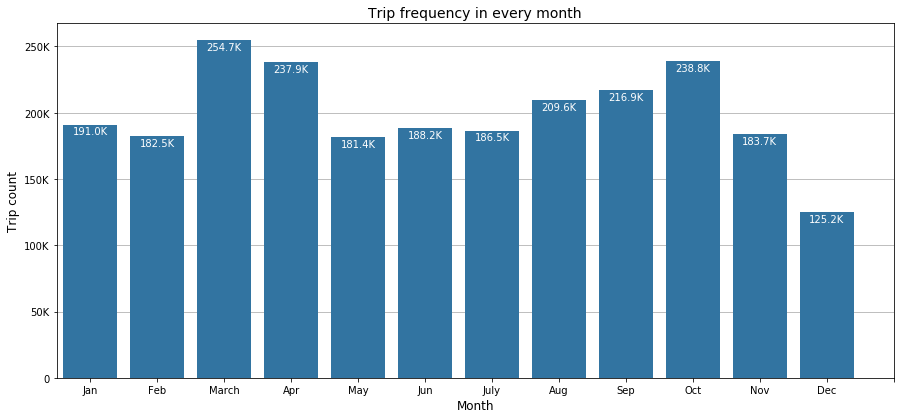

In [16]:
plt.figure(figsize = [15,30]);

plt.subplot(4,1,1)
base_color = sb.color_palette()[0]
data = df_trips['start_time'].dt.month.reset_index()
plt.title('Trip frequency in every month', fontsize = 14)
sb.countplot(data=data, x='start_time', color=base_color);
locs, lables = plt.xticks()
for loc,label in zip(locs, lables):
    count = len(data[data['start_time'] == int(label.get_text())])
    plt.text(loc, count-7500,str(round(count/1000,1)) +'K', ha='center', color='w' )   
plt.xticks(np.arange(0,13,1),['Jan','Feb','March','Apr','May','Jun','July','Aug','Sep','Oct','Nov', 'Dec']);
plt.yticks(np.arange(0,300000, 50000), ['0','50K','100K','150K','200K','250K']);
plt.xlabel('Month', fontsize=12);
plt.ylabel('Trip count', fontsize=12);
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True


Text(4, 50000, 'Total gass saved in 2019: 443.98k litters')

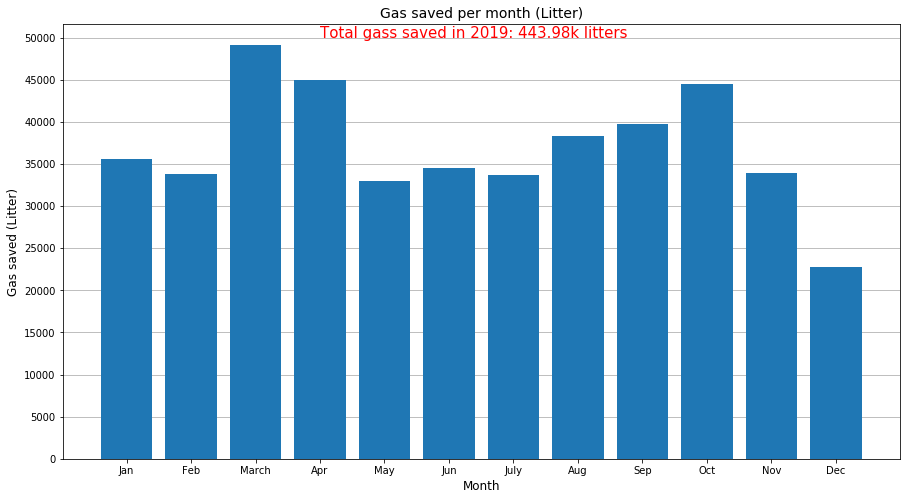

In [17]:
data = df[['distance','start_time']].groupby(df['start_time'].dt.month).sum().reset_index()
#Distance to km
data['distance'] = data['distance']/1000
# Considering 10 litter of gass per 100 km. 
data['gas_saved'] = data['distance']/10
fig = plt.figure(figsize=(15,8))
ax = fig.add_axes([.125, .125, .775, .755])
ax.bar(data = data, height='gas_saved', x='start_time');
ax.ticklabel_format(style='plain')
plt.xticks(np.arange(1,13,1),['Jan','Feb','March','Apr','May','Jun','July','Aug','Sep','Oct','Nov', 'Dec']);
plt.xlabel('Month', fontsize = 12)
plt.ylabel('Gas saved (Litter)', fontsize = 12)
plt.yticks(np.arange(0,50001,5000))#,['0','5m','10m','15m','20m','25m','30m','35m','40m','45m','50m'])
plt.title('Gas saved per month (Litter)',fontsize = 14)
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True

total = round(data['gas_saved'].sum()/1000,2)
plt.text(x=4, y=50000, s='Total gass saved in 2019: '+str(total)+ 'k litters', fontsize=15, color='red')

### User Type
80.63% of the users are Subscribers and 19.37% of them are casual customers.

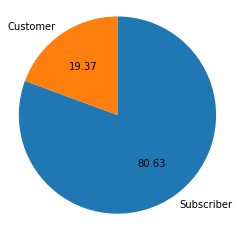

In [18]:
data = df_trips.user_type.value_counts()
plt.pie(data, labels = data.index, startangle=90, counterclock=False, autopct='%.2f');
plt.axis('square');

### Trip duration analysis:
> - In the data we have little number of trips longer than 2 hours which most of them have very low speed (0.44 km/h). It shows during these trips most of the time the bike was idle. I removed these trips for future analysis.  
- Most of the trips (about 900k) are between 5 to 10 minutes. Considering the average speed of 20 km/h, it means most of the trips are between 1.5 to 3 km.
- About 550k of the trips are between 10 to 15 minutes, which is about 3 to 4.5 km in distance. 
- The number of trips with a trip duration of fewer than 5 minutes is considerable (400k). It shows people use bikes for a short time and probably short distances. It can justify having stations close together.
- The number of trips with longer times decreases to the extent that we have only 3k trips with a duration of one hour and 600 trips for 2-hour trips. 
- The entire histogram shows people use bikes for relatively short times.

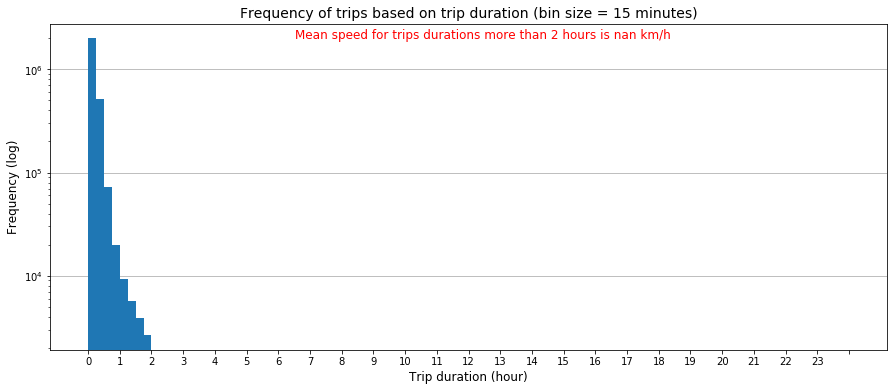

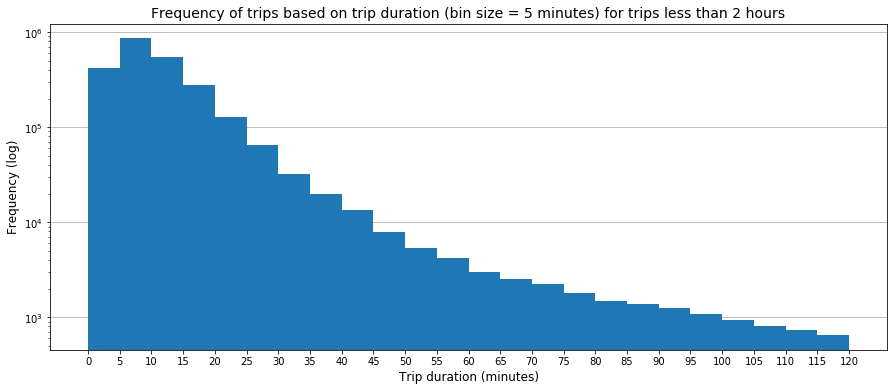

In [19]:
#Trip duration histogram for the entire data
plt.figure(figsize=[15,6])
bins= np.arange(0, 24*3600+1, 900)
plt.hist(data=df, x='duration_sec', bins=bins);
plt.xticks(np.arange(0, 24*3600+1, 3600),np.arange(0, 24, 1));
plt.yticks(np.arange(0, 1500001, 500000),['0','500K','1000K','1500K']);
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True
plt.title('Frequency of trips based on trip duration (bin size = 15 minutes)', fontsize = 14)
plt.xlabel('Trip duration (hour)', fontsize =12)
plt.ylabel('Frequency (log)', fontsize = 12)
speed = round(df.query('duration_sec > 2*3600')['speed'].mean(),2)
plt.yscale('log')
plt.text(x=23500,y=2000000, s='Mean speed for trips durations more than 2 hours is '+str(speed)+' km/h',fontsize = 12, color='red')

# Trip duration histogram
plt.figure(figsize=[15,6])
bins= np.arange(0, 2*3600+1, 300)
plt.hist(data=df_trips, x='duration_sec', bins=bins);
plt.xticks(np.arange(0, 2*3600+1, 300),np.arange(0, 121, 5));
plt.yticks(np.arange(0, 900001, 200000),['0','200K','400K','600K','800K']);
plt.title('Frequency of trips based on trip duration (bin size = 5 minutes) for trips less than 2 hours', fontsize = 14)
plt.xlabel('Trip duration (minutes)', fontsize =12)
plt.ylabel('Frequency (log)', fontsize = 12)
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True
plt.yscale('log')


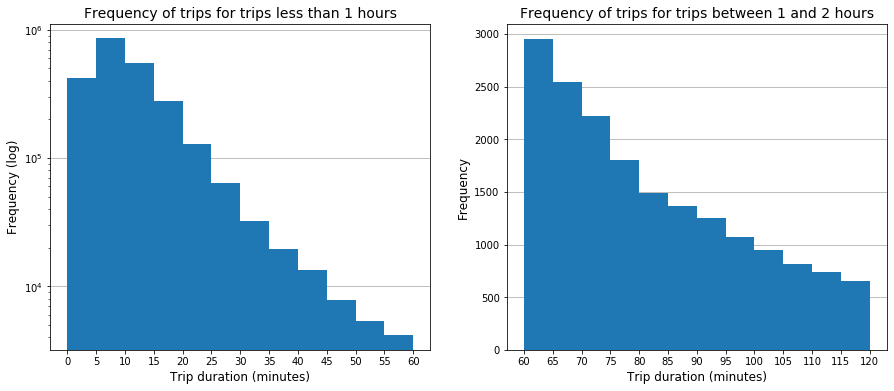

In [20]:

# Trip duration histogram for less than an hour and between one and two hours
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
data = df_trips.query('duration_sec <= 3600')
bins= np.arange(0, 3600+1, 300)
plt.hist(data=data, x='duration_sec', bins=bins);
plt.xticks(np.arange(0, 3601, 300),np.arange(0, 61, 5));
plt.yticks(np.arange(0, 900001, 200000),['0','200K','400K','600K','800K'])
plt.title('Frequency of trips for trips less than 1 hours', fontsize = 14)
plt.xlabel('Trip duration (minutes)', fontsize =12)
plt.ylabel('Frequency (log)', fontsize = 12)
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True
plt.yscale('log')

plt.subplot(1,2,2)
data = df_trips.query('duration_sec > 3600')
bins= np.arange(3600, 2*3600+1, 300)
plt.hist(data=data, x='duration_sec', bins=bins);
plt.xticks(np.arange(3600, 2*3600+1, 300),np.arange(60, 121, 5));
plt.title('Frequency of trips for trips between 1 and 2 hours', fontsize = 14)
plt.xlabel('Trip duration (minutes)', fontsize =12)
plt.ylabel('Frequency', fontsize = 12)
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True

### suspicious activities
>We can call two types of activities suspicious:
1. Trips with long distance in a short time (very quick trips): There may be cases that bikes were moved by car.
    - There is a trip with a speed of 70. The bike which was used in this trip is moved from San Francisco to San Jose and never had a trip after this trip, which is very suspicious.
3. Trips with very long duration (more than 5 hours)
    - There are 1967 trips with a long duration. Most probably, bikes were idle during these trips. One scenario is that the user did not disconnect from the bike, and the trip continued.

Text(45000, 270, 'Number of all the trips with trip\nduration more than 10 hours: 1967')

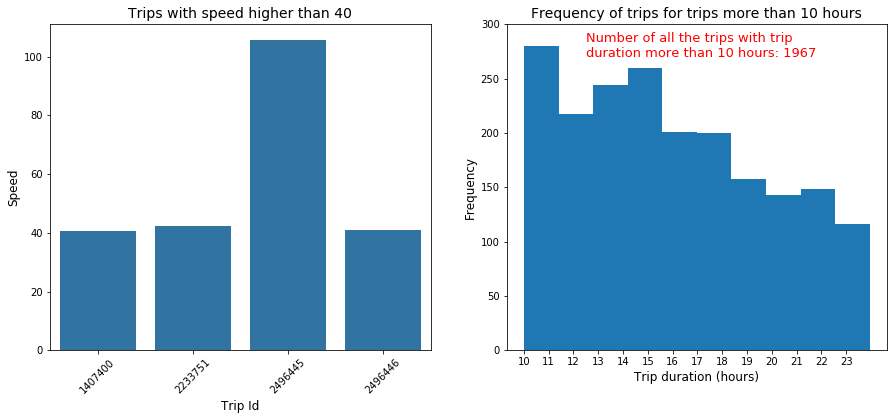

In [21]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
data = df.query('speed > 40')
sb.barplot(data = data , x=data.index, y='speed', color=sb.color_palette()[0],ci=None);
plt.tick_params(axis='x', rotation=45)
plt.title('Trips with speed higher than 40', fontsize = 14)
plt.xlabel('Trip Id', fontsize =12)
plt.ylabel('Speed', fontsize = 12)

plt.subplot(1,2,2)
data = df_full.query('duration_sec > 10*3600');
plt.hist( x=data['duration_sec']);
plt.xticks(np.arange(36001, data.duration_sec.max(), 3600),np.arange(10, 24, 1));
plt.yticks(np.arange(0, 301, 50),['0','50','100','150','200','250','300']);
plt.title('Frequency of trips for trips more than 10 hours', fontsize = 14)
plt.xlabel('Trip duration (hours)', fontsize =12)
plt.ylabel('Frequency', fontsize = 12)
sum10 = df_full.query('duration_sec > 10*3600').shape[0]
plt.text(x=45000,y=270, s='Number of all the trips with trip\nduration more than 10 hours: '+str(sum10),fontsize = 13, color='red')

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Trip duration - frequency has a power-law distribution (Vast majority of the trips are less than 15 minutes, and a tiny number of trips are more than two hours). The trips with more than 2 hours of duration are too slow (mean speed is 0.44 km/h). It means for most of the trip duration, the bike was idle. So I removed trips with a duration of more than 2 hours.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Trip duration - frequency histogram is right-skewed in a way that reading the values from the chart was hard. I applied a log transmission to the frequency of the trips(y-axis). It is still right-skewed after the log transmission, but it is more readable.

<a id='Bivariate'></a>
## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

In [22]:
with open('auth', 'r') as file:
    key = file.read().replace('\n', '')
gmaps.configure(api_key=key)

### Station location distribution
>Stations are distributed in three cities; San Francisco(230 stations), Oakland(132) and San Jose(94). You can zoom on the map and see more details.

In [59]:
#markers = gmaps.marker_layer(df_stations[['start_station_latitude','start_station_longitude']])
markers = gmaps.symbol_layer(df_stations[['latitude','longitude']], fill_color='blue', stroke_color='blue',scale=1,fill_opacity=0.2 )
fig = gmaps.figure(center=(37.60158, -122.233234), zoom_level=10, layout={'width': '900px','height': '700px','padding': '3px','border': '1px solid black'})
fig.add_layer(markers)
embed_minimal_html('allStations.html', views=[fig])
fig


Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='900px'))

### Station location distribution in San Francisco
>Most of the stations are located on the west side of the city. Stations in the city center are closer together. By clicking on the markers, you can see the name and id of the station.

In [60]:
#San Francisco
locations = df_stations.query('city=="San Francisco"')[['latitude','longitude','station_id','name']].reset_index()
locations['text'] ='Station Id: ' +locations['station_id'].apply(str)+' - Name: '+ locations['name']
markers = gmaps.marker_layer(locations[['latitude','longitude']], info_box_content = locations['text'])
fig = gmaps.figure(center=(37.77498, -122.419234), zoom_level=13.3, layout={'width': '900px','height': '700px','padding': '3px','border': '1px solid black'})
fig.add_layer(markers)
embed_minimal_html('SanFranciscoStations.html', views=[fig])
fig

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='900px'))

### Station location distribution in Oakland
> Stations are located mostly in the city center. There are no stations in the north part of the city as well as the Central Berkeley district. By clicking on the markers, you can see the name and id of the station.

In [61]:
#Oakland
locations = df_stations.query('city == "Oakland"')[['latitude','longitude','station_id','name']].reset_index()
locations['text'] ='Station Id: ' +locations['station_id'].apply(str)+' - Name: '+ locations['name']
markers = gmaps.marker_layer(locations[['latitude','longitude']], info_box_content = locations['text'])
fig = gmaps.figure(center=(37.82448, -122.271234), zoom_level=12.5, layout={'width': '900px','height': '700px','padding': '3px','border': '1px solid black'})
fig.add_layer(markers)
embed_minimal_html('oaklandStations.html', views=[fig])
fig

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='900px'))

### Station location distribution in San Jose
> Stations are located mostly in the city center. By clicking on the markers, you can see the name and id of the station.

In [62]:
# San Jose
locations = df_stations.query('city == "San Jose"')[['latitude','longitude','station_id','name']].reset_index()
locations['text'] ='Station Id: ' +locations['station_id'].apply(str)+' - Name: '+ locations['name']
markers = gmaps.marker_layer(locations[['latitude','longitude']], info_box_content = locations['text'])
fig = gmaps.figure(center=(37.34058, -121.890234), zoom_level=13.3, layout={'width': '900px','height': '700px','padding': '3px','border': '1px solid black'})
fig.add_layer(markers)
embed_minimal_html('SanJoseStations.html', views=[fig])
fig

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='900px'))

### Hour of the trip considering user type:
>Subscribers tend to use bikes more during the peak-hours comparing to casual customers. The red line on the following figure shows the proportion of casual customers to the subscribers. As you see, the percentage decreases on the peak-hours, which explains that subscribers use the bikes as their commuting device. In other words, people who tend to commute by bike subscribe.

C:\Users\hak335\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\hak335\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



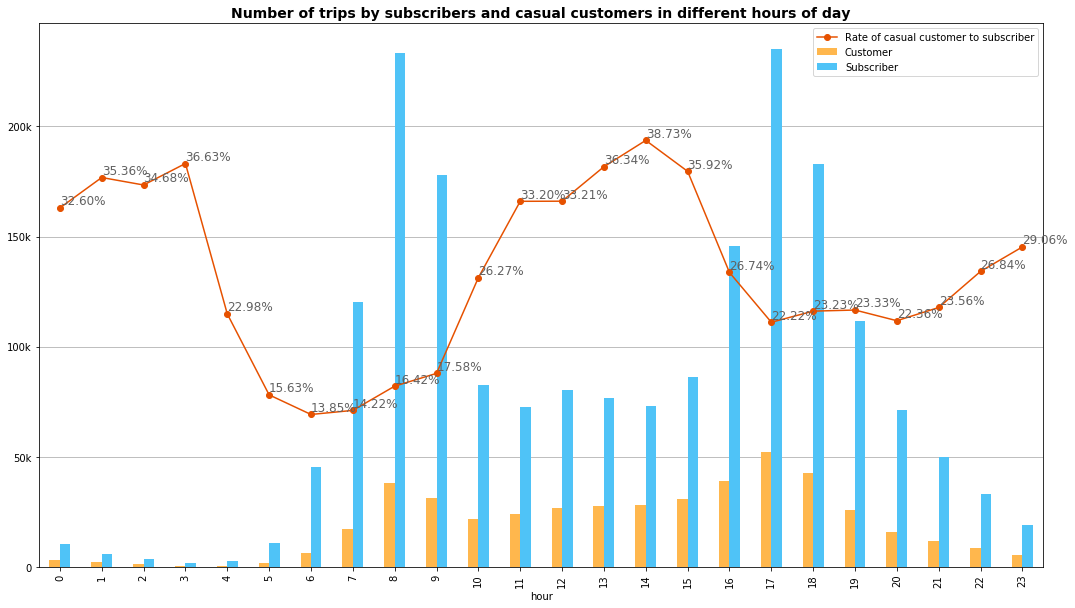

In [54]:
data = df_trips[['start_time','user_type']]
data.loc[:,'hour'] = data['start_time'].dt.hour
data = data.pivot_table(index='hour', columns='user_type',aggfunc='count')
data['rate'] = round(data[('start_time',   'Customer')]/data[('start_time',   'Subscriber')] * 100 , 2)
data['rate(5000x)'] = data['rate']*5000
data['rate'] = data['rate'].apply(lambda x: '{0:.2f}%'.format(x))
data = data.reset_index()
data.columns = ['hour','Customer','Subscriber','rate', 'rate(5000x)']

fig1, ax = plt.subplots(figsize=[18,10])
data['rate(5000x)'].plot(linestyle='-', marker='o', color = '#E65100')
data[['hour','Customer','Subscriber']].plot(x='hour', kind='bar', ax =ax, color=['#FFB74D','#4FC3F7'])
plt.title("Number of trips by subscribers and casual customers in different hours of day", fontsize = 14, fontweight='bold')
plt.legend(['Rate of casual customer to subscriber','Customer','Subscriber'])
plt.yticks(np.arange(0,200001,50000), ['0','50k','100k','150k','200k'])

x = ax.get_xticks()
for a,b,c in zip(x,data['rate(5000x)'], np.array( data['rate'])):
    plt.text(a,b+1500,c, color='#616161', fontsize=12)
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True

### Day of the week considering user type
>During the weekdays, subscribers have more trips comparing to the weekends. This number does not change for customers. Rate of casual customers to subscribers doubles at the weekends, which as another indication that most of the subscribers use bikes for commuting.

In [28]:
data = df_trips[['start_time','user_type','start_weekday']]
data = data.pivot_table(index='start_weekday', columns='user_type',aggfunc='count')
data['rate'] = round(data[('start_time',   'Customer')]/data[('start_time',   'Subscriber')] * 100 , 2)
data['rate(5000x)'] = data['rate']*5000
data['rate'] = data['rate'].apply(lambda x: '{0:.2f}%'.format(x))
data = data.reset_index()
data.columns = ['hour','Customer','Subscriber','rate', 'rate(5000x)']

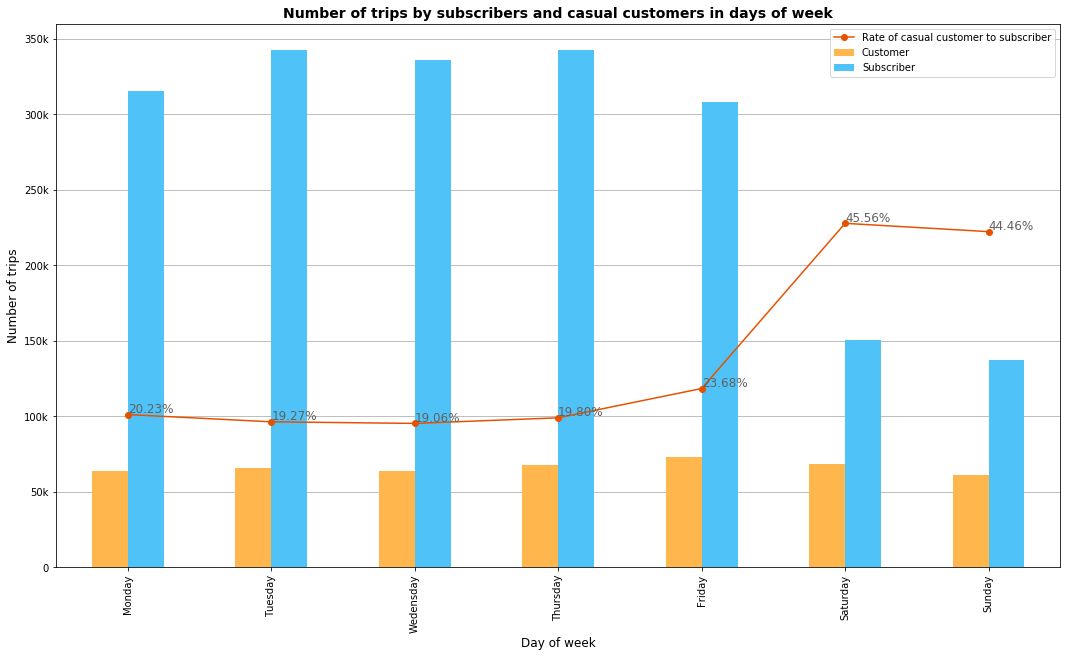

In [29]:
fig1, ax = plt.subplots(figsize=[18,10])
data['rate(5000x)'].plot(linestyle='-', marker='o', color = '#E65100')
data[['hour','Customer','Subscriber']].plot(x='hour', kind='bar', ax =ax, color=['#FFB74D','#4FC3F7'])
plt.title("Number of trips by subscribers and casual customers in days of week", fontsize = 14, fontweight='bold')
plt.legend(['Rate of casual customer to subscriber','Customer','Subscriber'])
plt.xticks([0,1,2,3,4,5,6],['Monday', 'Tuesday', 'Wedensday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);
plt.yticks(np.arange(0,350001,50000), ['0','50k','100k','150k','200k','250k','300k','350k'])
plt.ylabel('Number of trips', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
x = ax.get_xticks()
for a,b,c in zip(x,data['rate(5000x)'], np.array( data['rate'])):
    plt.text(a,b+1500,c, color='#616161', fontsize=12)
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True

### User type in cities
Rate of casual customers to subscribers is high in San Francisco(26.53%) comparing to Oakland(20.34%) and San Jose(12.58%). 

In [30]:
data = df[['start_time','user_type','city_x']]
data = data.pivot_table(index='city_x', columns='user_type',aggfunc='count')
data['rate'] = round(data[('start_time',   'Customer')]/data[('start_time',   'Subscriber')] * 100 , 2)
data['rate(20000x)'] = data['rate']*20000
data['rate'] = data['rate'].apply(lambda x: '{0:.2f}%'.format(x))
data = data.reset_index()
data.columns = ['hour','Customer','Subscriber','rate', 'rate(20000x)']

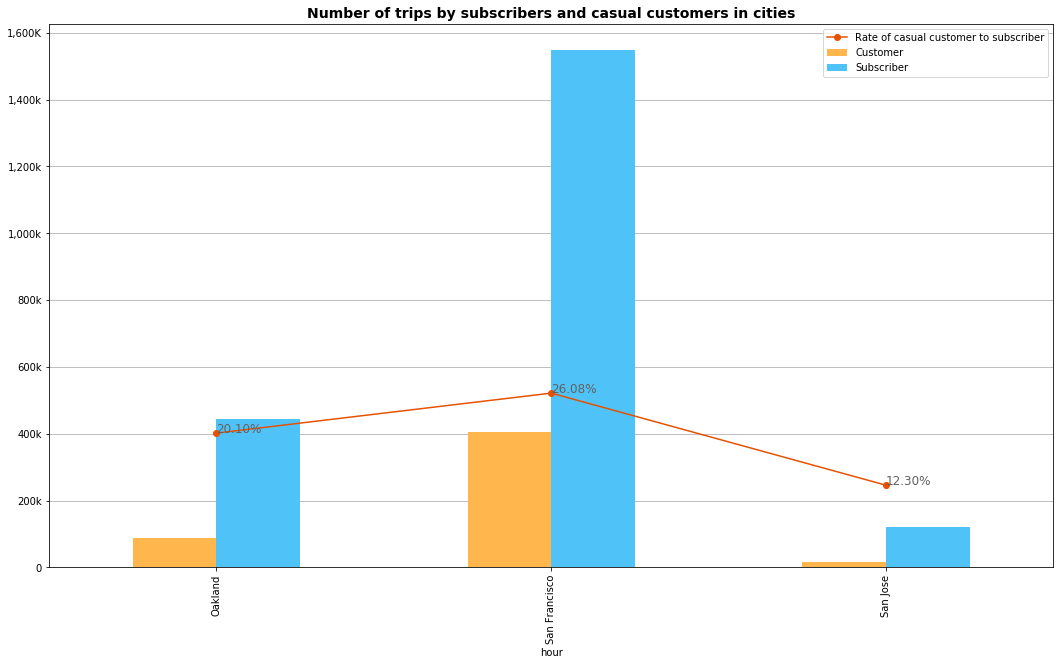

In [31]:
fig1, ax = plt.subplots(figsize=[18,10])
data['rate(20000x)'].plot(linestyle='-', marker='o', color = '#E65100')
data[['hour','Customer','Subscriber']].plot(x='hour', kind='bar', ax =ax, color=['#FFB74D','#4FC3F7'])
plt.title("Number of trips by subscribers and casual customers in cities", fontsize = 14, fontweight='bold')
plt.legend(['Rate of casual customer to subscriber','Customer','Subscriber'])
plt.yticks(np.arange(0,1600001,200000), ['0','200k','400k','600k','800k','1,000k','1,200k','1,400k','1,600K'])

x = ax.get_xticks()
for a,b,c in zip(x,data['rate(20000x)'], np.array( data['rate'])):
    plt.text(a,b+1500,c, color='#616161', fontsize=12)
plt.grid(True, axis='y')
plt.rcParams['axes.axisbelow'] = True

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> There is an interesting relationship between the user type and the time of the trips. Subscribers use the bikes during the peak-hours more frequently comparing to casual customers. The number of trips drops for subscribers at the weekends while this number is not changing for casual customers. It shows people who want to use the bike-sharing system subscribe or people who subscribe are more likely to use bikes for commuting.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Distribution of the stations is different in each city depending on the city's structure. In San Francisco, most of the stations are located on the west side of the town. In San Jose, most of the cities are in the city center, and in Oakland, stations are scattered south to north with a high density in the center.

<a id='Multivariate'></a>
## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Number of trips per station in San Francisco
>The following heatmap shows the amount of traffic for each station in San Francisco. The larger circles indicate higher trips starting from the station. Stations on the west and center of the town having more trips. Some stations on the east and south side of the city have very little traffic.

In [63]:
#San Francisco
locations = df.query('city_x=="San Francisco"')[['latitude_x','longitude_x']].groupby(['latitude_x','longitude_x']).size().reset_index()
locations.columns = ['latitude_x', 'longitude_x', 'count']
weights = locations['count']

fig = gmaps.figure(center=(37.77498, -122.419234), zoom_level=13, layout={'width': '900px','height': '700px','padding': '3px','border': '1px solid black'})
heatmap_layer = gmaps.heatmap_layer(locations[['latitude_x','longitude_x']],weights )
heatmap_layer.max_intensity = 200
heatmap_layer.point_radius = 7
fig.add_layer(heatmap_layer)
embed_minimal_html('SanFranciscoTrips.html', views=[fig])
fig

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='900px'))

### Number of trips per station in San Jose
>The following heatmap shows the amount of traffic for each station in San Jose. The larger circles indicate higher trips starting from the station. Stations on the downtwon having more trips. Some stations on the north and south side of the city have very little traffic.

In [64]:
#San Jose
locations = df.query('city_x=="San Jose"')[['latitude_x','longitude_x']].groupby(['latitude_x','longitude_x']).size().reset_index()
locations.columns = ['latitude_x', 'longitude_x', 'count']
weights = locations['count']

fig = gmaps.figure(center=(37.34058, -121.890234), zoom_level=13.3, layout={'width': '900px','height': '700px','padding': '3px','border': '1px solid black'})
heatmap_layer = gmaps.heatmap_layer(locations[['latitude_x','longitude_x']],weights )
heatmap_layer.max_intensity = 200
heatmap_layer.point_radius = 7
fig.add_layer(heatmap_layer)
embed_minimal_html('SanJoseTrips.html', views=[fig])
fig

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='900px'))

### Number of trips per station in Oakland
>The following heatmap shows the amount of traffic for each station in Oakland. The larger circles indicate higher trips starting from the station. Stations on the downtwon having more trips. Some stations on the south side of the city have very little traffic.

In [65]:
#Oaklan
locations = df.query('city_x=="Oakland"')[['latitude_x','longitude_x']].groupby(['latitude_x','longitude_x']).size().reset_index()
locations.columns = ['latitude_x', 'longitude_x', 'count']
weights = locations['count']

fig = gmaps.figure(center=(37.82448, -122.271234), zoom_level=12.7, layout={'width': '900px','height': '700px','padding': '3px','border': '1px solid black'})
heatmap_layer = gmaps.heatmap_layer(locations[['latitude_x','longitude_x']],weights )
heatmap_layer.max_intensity = 200
heatmap_layer.point_radius = 7
fig.add_layer(heatmap_layer)
embed_minimal_html('oaklandTrips.html', views=[fig])
fig

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='900px'))

### Trip distance and duration
>The following scatter plot shows the mean duration and distance of trips for each day. Each circle represents a day, and the size of the circle shows the number of trips on that day. Each city is shown in a different colour. You can see the detail of the day with hovering the mouse on a point. Generally, people in San Francisco use bikes for longer distances and more extended time. In San Jose, trips are shorter compared to the other two cities. There is an unusual data point on September 22nd in San Jose, where trip duration is almost two times more than a regular day.

In [50]:
data = df.groupby([df['city_x'],df['start_time'].dt.date]).agg({'distance':'mean','duration_sec': 'mean', 'station_id_x': 'count', 'speed':'mean'}).reset_index()
data.columns = ['city', 'start_time', 'distance', 'duration', 'count','speed']

fig = px.scatter(data, y='distance',x='duration', color='city',size="count",hover_name="start_time")
fig.update_layout(
    title="Trip distance-duration scatter plot",
    xaxis_title="Distance(km)",
    width=960,
    height=720,
    legend_orientation="h",
    legend=dict(x=0, y=1.05),
    yaxis_title="Duration(mins)",
    font=dict(size=14,color="#7f7f7f"))
fig.show()
plotly.offline.init_notebook_mode(connected=True)

### Trip distance and time
>The following scatter plot shows the mean distance and time of trips. Each circle represents a day, and the size of the circle shows the number of trips on that day. Each city is shown in a different colour. You can see the detail of the day with hovering the mouse on a point.

In [51]:
fig = px.scatter(data, y='distance',x='start_time', color='city',size="count",hover_name="start_time")
fig.update_layout(
    title="Trip distance-time scatter plot",
    xaxis_title="Time",
    width=960,
    height=720,
    legend_orientation="h",
    legend=dict(x=0, y=1.05),
    yaxis_title="Distance(km)",
    font=dict(size=14,color="#7f7f7f"))
fig.show()

### Trip distance and time
>The following scatter plot shows the mean distance and time of trips. Each circle represents a day, and the size of the circle shows the number of trips on that day. Each city is shown in a different colour. You can see the detail of the day with hovering the mouse on a point.

In [52]:
fig = px.scatter(data, y='duration',x='start_time', color='city',size="count",hover_name="start_time")
fig.update_layout(
    title="Trip duration-time scatter plot",
    xaxis_title="Duration(km)",
    width=960,
    height=720,
    legend_orientation="h",
    legend=dict(x=0, y=1.05),
    yaxis_title="Duration(mins)",
    font=dict(size=14,color="#7f7f7f"))
fig.show()

### Trip duration box plot in each city based on user type
>The following box plot shows the distribution of trip duration for Subscribers and casual customers. I have devided data to four categories. 
- Trips with less than 30 minutes duration.
- Between 30 minutes to hour.
- Between one hour to one hour and 30 minutes.
- Between one hour and 30 minutes to two hours.

<Figure size 1080x1080 with 0 Axes>

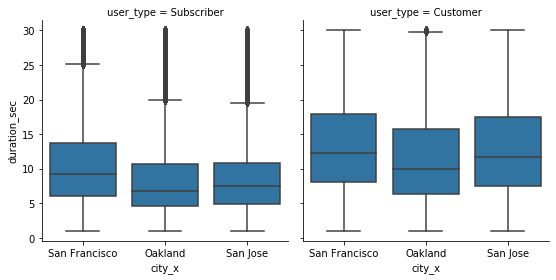

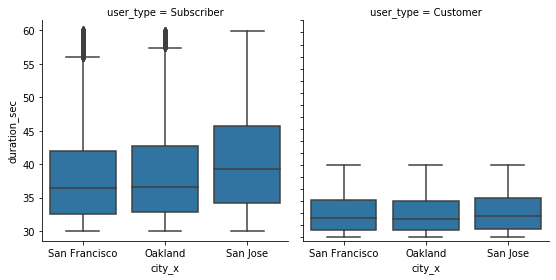

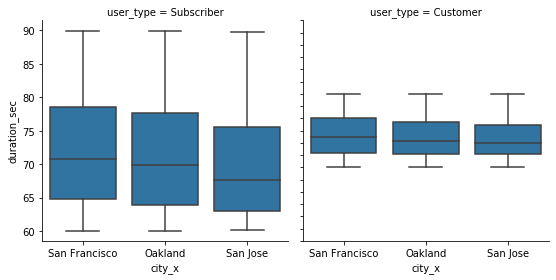

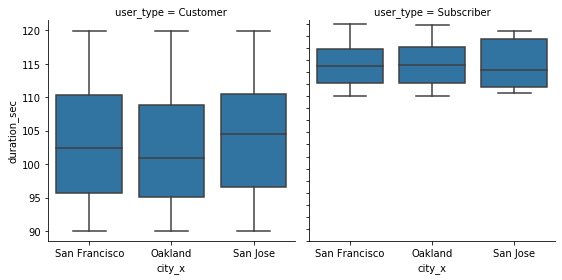

In [38]:
plt.figure(figsize=[15,15])

data = df.query('duration_sec <= 1800')
g = sb.FacetGrid(data = data, col ='user_type', height = 4)
g.map(sb.boxplot,'city_x', 'duration_sec',order=["San Francisco","Oakland","San Jose"] );
plt.yticks(np.arange(0,1801,300), np.arange(0,31,5));

data = df.query('duration_sec > 1800 and duration_sec <= 3600')
g = sb.FacetGrid(data = data, col ='user_type', height = 4)
g.map(sb.boxplot,'city_x', 'duration_sec',order=["San Francisco","Oakland","San Jose"] );
plt.yticks(np.arange(1800,2*3600+1,300), np.arange(30,121,5));

data = df.query('duration_sec > 3600 and duration_sec <= 5400')
g = sb.FacetGrid(data = data, col ='user_type', height = 4)
g.map(sb.boxplot,'city_x', 'duration_sec',order=["San Francisco","Oakland","San Jose"] );
plt.yticks(np.arange(1800,2*3600+1,300), np.arange(30,121,5));

data = df.query('duration_sec > 5400 and duration_sec <= 7200')
g = sb.FacetGrid(data = data, col ='user_type', height = 4)
g.map(sb.boxplot,'city_x', 'duration_sec',order=["San Francisco","Oakland","San Jose"]);
plt.yticks(np.arange(1800,2*3600+1,300), np.arange(30,121,5));

### Travel between cities

In [39]:
data = df_full.query('city_x != city_y').groupby(['city_x','city_y']).size().reset_index()
data = data.pivot_table(index = 'city_x', columns = 'city_y')
data.columns = ['Oakland','San Francisco','San Jose']

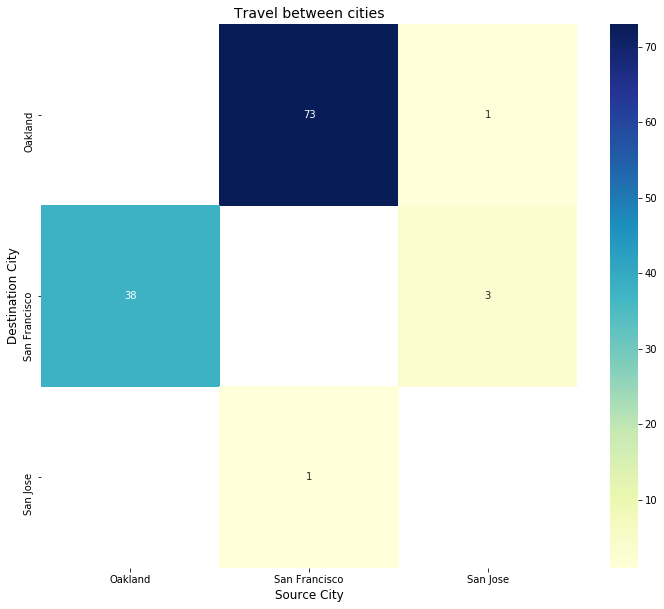

In [40]:
plt.figure(figsize=(12,10))
sb.heatmap(data = data, annot=True, cmap="YlGnBu");
plt.title('Travel between cities',fontsize=14)
plt.xlabel('Source City', fontsize=12);
plt.ylabel('Destination City',fontsize=12);

In [41]:
data = df_full.query('city_x != city_y').groupby(['city_x', 'city_y','start_station_id','end_station_id']).size().reset_index()
data.columns = ['city_x', 'city_y','source', 'destination', 'count']
oakland = list(dict.fromkeys(list(data.query('city_x == "Oakland"')['source'])))
sanJose = list(dict.fromkeys(list(data.query('city_x == "San Jose"')['source'])))

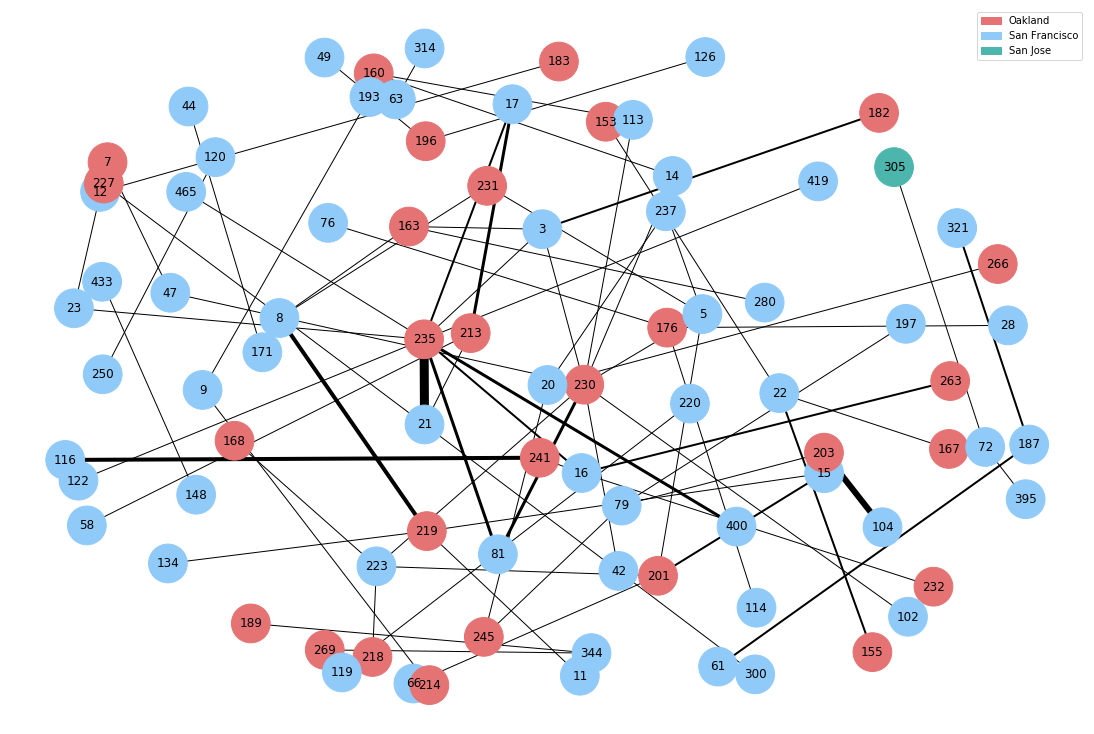

In [42]:
import matplotlib.patches as mpatches
G = nx.from_pandas_edgelist(data, 'source', 'destination', 'count')

plt.figure(3,figsize=(15,10)) 
pos = nx.spring_layout(G,k=0.5,iterations=30)
node_colors = ['#E57373'  if node in oakland else '#4DB6AC' if node in sanJose else '#90CAF9' for node in G.nodes()]

edges = G.edges()
weights = [G[u][v]['count'] for u,v in edges]

nx.draw(G,pos,with_labels=True,node_size=1500,width=(weights), node_color=node_colors,edge_labels='test', edges=edges)


red_patch = mpatches.Patch(color='#E57373', label='Oakland')
green_patch = mpatches.Patch(color='#4DB6AC', label='San Jose')
blue_patch = mpatches.Patch(color='#90CAF9', label='San Francisco')
plt.legend(handles=[red_patch, blue_patch,green_patch]);

### Route for most frequent out of twon travel

In [43]:
df_stations.query('station_id == 21 or station_id == 235')[['latitude','longitude']]

,latitude,longitude
18,37.789625,-122.400811
217,37.807239,-122.289370


In [44]:
station_21 = (37.789625, -122.400811)
station_235 = (37.807239, -122.289370)
fig = gmaps.figure(center=(37.80498, -122.339234), zoom_level=13, layout={'width': '900px','height': '700px','padding': '3px','border': '1px solid black'})
geneva2zurich = gmaps.directions_layer(station_21, station_235)
fig.add_layer(geneva2zurich)
fig

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='3px', width='900px'))

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> There is a relationship between location of a station and traffic of level of the station in each city. Mostly station in the downtown have more trip frequency. There is also a close relationship between the trip duration and user type.

### Were there any interesting or surprising interactions between features?

> Corolation between trip distance and cities is intresting. Trip distance is longer in San Francisco comparing to Oakland and San Jose. Trip distance is suprisingly less in San Jose comparing to San Francisco.

<a id='conclusion'></a>
# Conclusion
1. **Is there any relationship between the day of the week and trip duration, distance and speed?** 
    - Trip duration is considerably higher at weekends.
    - The number of trips is lower at weekends.
    - People tend to ride faster during weekdays comparing to weekdays.
    - Trip distance is slightly smaller at the weekends.
2. **How are the stations distributed geographically?**
    - In San Francisco, most of the stations are located at the center and west side of the city.
    - In Oakland, stations are scattered from south to north with a high-density downtown. 
    - The city center hosts the most station in San Jose.
3. **What time in a day do people use bikes more frequently?**
    - From 7 am to 9 am, and from 4 pm to 6 pm is the most crowded hours. Usage during these hours is considerably higher for subscribers comparing to casual users.


4. **How did bike usage change in different months?**
    - The number of trips is higher in March, April and October. January, February, November and December are the most rainest months in this region. May, July, Jun and August are the hottest months with direct sun. It seems people select a bike when the weather is not too rainy or too sunny.
5. **How different users (Subscribers or casual customers) use bikes?**
    - Subscribers use bikes more during peak hours and weekdays. Most probably, their purpose is to commute to work. Casual customer usage is not showing a significant difference in different hours and days.
6. **How subscribers' and casual users' trips are distributed in each city?**
    - In San Francisco, 26.08% of trips are done by casual customers. This number for Oakland and San Jose is 20.10% and 12.30%, respectively.


7. **Are there any suspicious activities?**
    - There are some trips with surprising speed. The standard speed for a bike is 18 to 30 km/h. However, there are some trips with a very high speed, which is suspicious. For example, speed for a journey was more than 70 km/h, which is highly questionable. After investigating the trip, I realized that the bike was moved from San Francisco to San Jose, and there is no travel history for the bike after that. Trips with a very high duration also investigated. Most probably, the bike was idle for the time, or the user has finished the trip, but the application did not consider the journey as ended.
8. **Is there any travel between cities?** 
    - There is 116 travel between cities in 2019. 
    - Seventy-three of them are from San Fransisco to Oakland.
    - Thirty-eight trips took place from Oakland to San Francisco.
    - Three trips from San Jose to San Francisco.
    - Only one trip from San Jose to Oakland.
    - One trip From San Francisco to San Jose.
9. **How much gas have been saved by the Ford GoBike system?**
    - The bike-sharing system saved about half a million litter gas.